### U-Net Implementation 
    1. Implemented with Tensorflow and Keras
    2. Trained and tested on CityScapes Dataset

In [2]:
seed=1
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K


import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import h5py
from collections import deque
from copy import copy,deepcopy
from tqdm import tqdm,trange
import time
import zlib

train=False
physical_devices=tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_data_root='D:/City_Scapes/Data/train/*'
val_data_root='D:/City_Scapes/Data/val/*'
log_dir='E:\\Deep-Learning-For-Robotics\\DeepSteer\\logs\\'
exp_name='exp-Seg104/'
batch_size=16
epochs=50
learning_rate=10e-4
image_w=256
image_h=144
out_ch=3
loss_func='categorical_crossentropy'

param_str=''
param_str+='batch_size : '+str(batch_size)+'\n'
param_str+='learning_rate : '+str(learning_rate)+'\n'
param_str+='epochs : '+str(epochs)+'\n'
param_str+='epochs : '+str(epochs)+'\n'
param_str+='image_w : '+str(image_w)+'\n'
param_str+='image_h : '+str(image_h)+'\n'
param_str+='out_ch : '+str(out_ch)+'\n'
param_str+='loss_func : '+str(loss_func)+'\n'
if not os.path.exists(log_dir+exp_name): os.makedirs(log_dir+exp_name)
with open(log_dir+exp_name+'param.txt','w') as file:
    file.write(param_str)

In [4]:
train_data=[]
for _dir in glob.glob(train_data_root):
    for path in glob.glob(_dir+'/*'):
        train_data.append(path)
val_data=[]
for _dir in glob.glob(val_data_root):
    for path in glob.glob(_dir+'/*'):
        val_data.append(path)

In [5]:
road_id=np.array([128,64,128],dtype=np.float32)
car_id=np.array([142,0,0],dtype=np.float32)

_ranges=[road_id,car_id]

def batch_generator(_data):
    no_of_batch=len(_data)//batch_size
    batch_index=np.arange(no_of_batch)

    
    batch_data=np.zeros((batch_size,image_h,image_w,3))
    batch_label=np.zeros((batch_size,image_h,image_w,out_ch))
        
    while(True):
        for ind in batch_index:
            k=0
            for j in range(ind*batch_size,(ind+1)*batch_size):
                    fname=_data[j]
                    img_a=cv2.imread(fname)[:850,:,:]
                    img_a=cv2.resize(img_a,(image_w,image_h))
                    batch_data[k,:,:,:]=(img_a/255.0)
                    
                    label_fname=fname.replace('Data','Label')[:-15]+'gtFine_color.png'

                    label_img=cv2.imread(label_fname)[:850,:,:]
                    label_img=cv2.resize(label_img,(image_w,image_h))

                    label=np.zeros((image_h,image_w,out_ch),dtype=np.float32)
                    back_ground=0
                    for ind,_range in enumerate(_ranges[:out_ch-1]):
                        lower = _range-5; upper = _range+5
                        seg_img=cv2.inRange(label_img,lower,upper)
                        label[:,:,ind]=seg_img
                        back_ground+=seg_img
                    label[:,:,-1]=np.array(~(back_ground),dtype=np.float32)
                    batch_label[k,:,:,:]=(label/255.0)
                
                    k+=1
            yield ([batch_data],[batch_label])#,batch_flow_2,batch_flow_3,batch_flow_4,batch_flow_5])

In [6]:
train_batch=batch_generator(train_data)
val_batch=batch_generator(train_data)

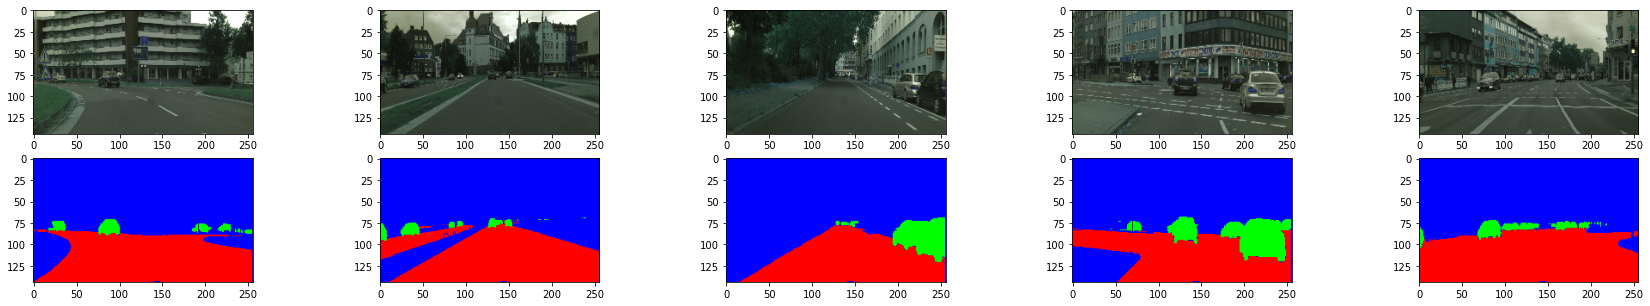

In [7]:
sample=next(train_batch)
fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(30,5))
for i,[img,label] in enumerate(zip(sample[0][0][:5],sample[1][0])):
    axes[0,i].imshow(img)
    axes[1,i].imshow(label[:,:,:])

In [8]:
N=64
def unet(input_size = (image_h,image_w,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(2*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(2*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(4*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(4*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(8*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(8*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(16*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(16*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(8*N, 3,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(8*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(8*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(4*N, 3,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(4*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(4*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(2*N, 3,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(2*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(2*N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(N, 3,strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(N, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    if out_ch==1:conv10 = Conv2D(out_ch, 1, activation = 'sigmoid')(conv9)
    if out_ch>1:conv10 = Conv2D(out_ch, 1, activation = 'softmax')(conv9)
    

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = learning_rate), loss = loss_func, metrics = ['accuracy'])
    
    model.summary()

    #if(pretrained_weights):
    #	model.load_weights(pretrained_weights)

    return model

model=unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 144, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 144, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 72, 128, 64)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
if train==True:
    _cb=tf.keras.callbacks.ModelCheckpoint(log_dir+exp_name+'best_model.hdf5', monitor='val_loss', verbose=0, save_best_only=True)
    history=model.fit_generator(train_batch,validation_data=val_batch,steps_per_epoch=len(train_data)//batch_size,validation_steps=len(val_data)//batch_size,epochs=epochs,callbacks=[_cb])

In [10]:
if train==True:
    fig=plt.figure(figsize=(10,5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.show()
    fig.savefig('loss_curve_50_.png')
    with open(log_dir+exp_name+'loss_log.pkl','wb') as file:
        pickle.dump([loss,val_loss],file)
    model.save(log_dir+exp_name+'50.hdf5')

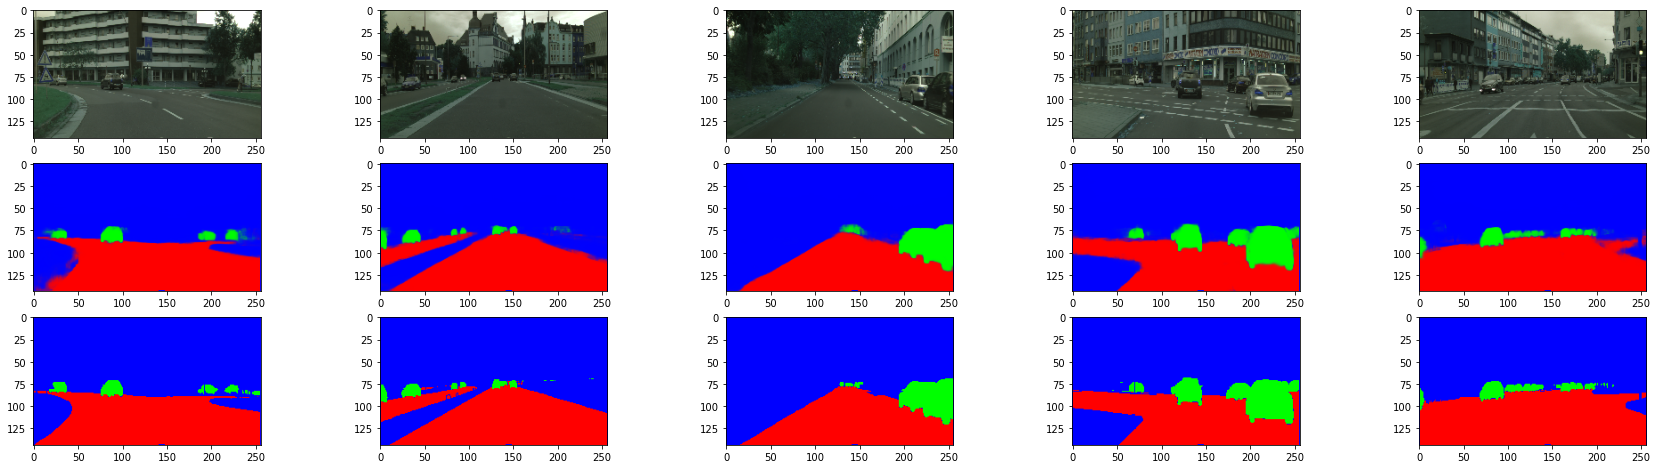

In [11]:
from matplotlib import pyplot as plt
sample=next(val_batch)
res=np.zeros((image_w,image_h,3),dtype=np.float64)
res1=np.zeros((image_w,image_h,3),dtype=np.float64)
model.load_weights(log_dir+exp_name+'best_model.hdf5')
pred=model.predict(sample[0][0])
fig,axes=plt.subplots(nrows=3,ncols=5,figsize=(30,8))
for i,[img,pred,label] in enumerate(zip(sample[0][0][:5],pred,sample[1][0])):
    axes[0,i].imshow(img)
    axes[1,i].imshow(pred[:,:,:])
    axes[2,i].imshow(label[:,:,:])
fig.savefig(log_dir+exp_name+'result.png')

### Thank You